<h1 style="font-size:30px;">Transfer Learning using VGG-16 (Fine Tuning Pre-Trained Layers)</h1>  

In the previous notebook, we demonstrated that we could use **transfer learning** to create a new classifier for the ASL dataset. However, we showed that freezing the entire convolutional base with pre-trained weights from ImageNet training did not result in a highly effective classifier. This is due to the fact that the ImageNet weights do not capture some of the unique features that are required for ASL dataset. In this notebook, we are going to introduce a hybrid approach to transfer learning where we use pre-trained weights for the first several layers of the network (that have learned more general features from ImageNet) and then allow the model to tune the weights for the subsequent convolutional blocks (plus the fully connected layers). This approach is called **fine-tuning** because it makes small adjustments to the more abstract representations of the model being reused to make them more relevant for the problem at hand.

**The transfer learning and fine-tuning process is summarized below:**

1. Instantiate the VGG-16 convolutional base with pre-trained weights from ImageNet
2. Configure the convolutional base as "trainable"
3. Freeze all the layers in the convolutional base (EXCEPT the last four)
4. Add a dense classifier layer for the ASL dataset
5. Train the model (the last four layers of the convolutional base plus the dense classifier)

<img src='https://opencv.org/wp-content/uploads/2022/03/c4_03_cnn_vgg_pretrained_small_base_ASL.png' width=1000 align='center'><br/>

## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset and Training Configuration](#3-Dataset-and-Training-Configuration)
* [4 Fine-Tuning using the VGG-16 Model](#4-Fine-Tuning-using-the-VGG-16-Model)
* [5 Model Evaluation](#5-Model-Evaluation)
* [6 Conclusion](#6-Conclusion)
* [7 Quantization](#7-Quantization)
* [8 Compilation](#8-Compilation)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42 

2023-01-25 09:17:36.202603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu
2023-01-25 09:17:36.202626: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1 System Configuration

In [2]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


2023-01-25 09:17:38.693010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/cv2/../../lib64:/opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu
2023-01-25 09:17:38.693038: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-25 09:17:38.693056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


## 2 Download and Extract the Dataset

In [3]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [4]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [5]:
download_file(
    'https://www.dropbox.com/s/7huaqeavdbz32la/dataset_ASL_150.zip?dl=1', 
    'dataset_ASL_150.zip'
)
    
unzip(zip_file='dataset_ASL_150.zip')

Extracted all


## 3 Dataset and Training Configuration

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 29
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 32
    DATA_ROOT:   str = './dataset_ASL_150'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 32
    EPOCHS:         int   = 51
    LEARNING_RATE:  float = 0.0001
    CHECKPOINT_DIR: str   = './saved_models_asl'

## 4 Modeling VGG-16

The Keras API provides the following utility that is used to instantiate a VGG-16 model, which can be initialized with either pre-trained weights from ImageNet or random initial weights. **In this notebook, we will load the model with weights from the ImageNet dataset** as a starting point for **Fine-Tuning.** For more information on the VGG-16 model available in Keras, refer to the: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16" target="_blank">Keras VGG-16 Model API</a>

```python
tf.keras.applications.vgg16.VGG16(include_top=True, 
                                  weights='imagenet', 
                                  input_tensor=None,
                                  input_shape=None, 
                                  pooling=None, 
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )
```

### 4.1 How to Fine-Tune a Pre-Trained Model?
The general approach to **fine-tuning** a convolutional base is to first load the pre-trained weights for the model and then selectively allow the last few convolutional layers in the base to be **trainable**. The process of selectively specifying which layers are trainable and which ones are not is often referred to as freezing or un-freezing layers via the model's **`trainable`**  attribute. In the figure below, we show the convolutional base has been loaded with pre-trained weights from ImageNet. We then "freeze" the first portion of the convolutional base to preserve the features learned from ImageNet, but we allow the last four layers to be fine-tuned during the training process. We use the term "fine-tuning" in this context because we expect the last few layers of the convolutional base (pre-trained on ImageNet) to contain feature representations that are "pretty good", but require further refinement to be more relevant for the ASL dataset.

<img src='https://opencv.org/wp-content/uploads/2022/03/c4_03_cnn_vgg_pretrained_fine_tune.png' width=700 align='center'><br/>

Ideally, you should train the dense layers first (keeping the entire convolutional base frozen) as we did in the case of the "transfer learning with feature extraction experiment" and then start tuning the convolutional layers at a lower learning rate. However, in order to keep things simple in this example, we will train the model just once, which will include the last few layers of the convolutional base as well as the dense classifier. 

In practice, when fine-tuning a model, it is better to start with fine-tuning just a few layers at a time to see how the model responds. As we will see in this example, tuning both the convolutional base and the dense layers at a lower learning rate works without any issues. However, if you are training the full convolutional base for fine-tuning, you should try to train the dense layers first and then start fine-tuning. 

### 4.2 VGG Convolutional Base
We begin by creating a model of the VGG-16 convolutional base. We can do this by instantiating the model and setting `include_top = False`, which excludes the fully connected layers. In this notebook, we will instantiate the model with weights that were learned by training the model on the ImageNet dataset.

#### How to freeze only a few layers?
There are two ways to specify which layers in the model are trainable (tunable). 
1. We can start by making the entire convolutional base trainable by setting the `trainable` flag to `True`. Then loop over the **initial** layers and make them untrainable by setting the same (`trainable`) flag for each layer to `False`. 

2. We can freeze the entire convolutional base by setting the `trainable` flag to `False`, and then loop over the  **last** few layers and set the `trainable` flag to `True`.

We use the first approach in this notebook. In the code cell below, we start by setting the entire convolutional base as "trainable" by settng the `trainable` attribute to `True`.

In [7]:
print('Create an VGG16 model along with the imagenet pre-trained weights.')
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
vgg16_model_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False,
                                                    weights='imagenet',
                                                   )
# First make the convolutional base trainable.
vgg16_model_base.trainable = True
print('All weights trainable, fine tuning ...')

Create an VGG16 model along with the imagenet pre-trained weights.


2023-01-25 09:17:54.746284: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


All weights trainable, fine tuning ...


In [8]:
print(vgg16_model_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.3 Unfreeze the Last Four Layers for Fine-Tuning

In the previous section, we set the `trainable` attribute of the convolutional base to `True`. This now allows us to "freeze" a selected number of layers in the convolutional base so that only the last few layers in the convolutional base are trainable. 

In [9]:
print('Freeze the weights of the layers that we are not training')
for layer in vgg16_model_base.layers[:-4]:
    layer.trainable = False

Freeze the weights of the layers that we are not training


In [10]:
print(vgg16_model_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.4 Add the Classification Layer
Since we intend to train and use the model to classify hand signals from the ASL dataset (which has 29 classes), we will need to add our own classification layer. In this example, we have chosen to use just a single fully connected dense layer that contains 256 nodes, followed by a softmax output layer that contains 29 nodes for each of the 29 classes. The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset. This is the same approach we used in the previous notebook.

In [11]:
if False:
    print('Add Classification Layers (output or top)')
    # Take the output of the VGG16 just before last layer
    x = vgg16_model_base.layers[-1].output

    # Flatten the outputs of the last conv layer
    flatten = tf.keras.layers.Flatten(name='flatten')(x)

    # adding two fully connected layers. Meeting DPU requirement, keeping output/input ratio at @ 1/6
    #dense1 = tf.keras.layers.Dense(2048, activation= 'relu',name='fc1')(flatten)
    #dense2= tf.keras.layers.Dense(512, activation= 'relu',name='fc2')(dense1)
    dense = tf.keras.layers.Dense(256, activation= 'relu',name='fc')(flatten)

    # adding the prediction layer with 'softmax'
    #predictions = tf.keras.layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax',name='predictions')(dense2)
    predictions = tf.keras.layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax',name='predictions')(dense)

    # Create the new model with the new outputs
    model = tf.keras.Model(inputs=vgg16_model_base.input, outputs=predictions)
    
if True:
    print('Add Classification Layers (output or top)')
    # Take the output of the VGG16 just before last layer
    x = vgg16_model_base.layers[-1].output

    # Use conv2d instead of fully_connected layers.
    #x = tf.keras.layers.Conv2D(4096, (7, 7),name='fc1')(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    #x = tf.keras.layers.Conv2D(4096, (1, 1),name='fc2')(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(256, (7, 7),name='fc')(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    # adding the prediction layer with 'softmax'
    predictions = tf.keras.layers.Conv2D(DatasetConfig.NUM_CLASSES, (1, 1),name='predictions')(x)
    flatten = tf.keras.layers.Flatten(name='flatten')(predictions)
    softmax = tf.keras.layers.Activation('softmax',name='softmax')(flatten)

    # Create the new model with the new outputs
    model = tf.keras.Model(inputs=vgg16_model_base.input, outputs=softmax)


Add Classification Layers (output or top)


In [12]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.5 Prepare the Training and Validation Dataset

In [13]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='training',
                                             validation_split=0.2
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='validation',
                                             validation_split=0.2
                                            )

Found 4350 files belonging to 29 classes.
Using 3480 files for training.
Found 4350 files belonging to 29 classes.
Using 870 files for validation.


### 4.6 Display Sample Images

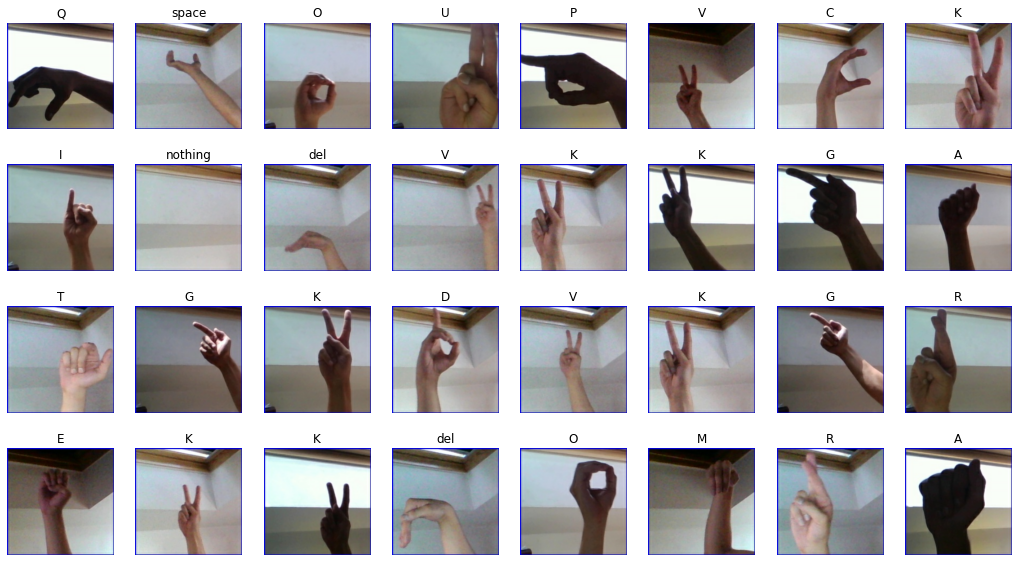

In [14]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

### 4.7 Compile and Train the Model

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [16]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

In [17]:
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

28/28 [==============================] - 74s 3s/step - loss: 25.0743 - accuracy: 0.0299
Model evaluation accuracy: 2.989


In [18]:
# Train the Model.
training_results = model.fit(train_dataset,
                                   validation_data=valid_dataset,
                                   epochs=TrainingConfig.EPOCHS,
                                   workers=4,
                                   use_multiprocessing=True, 
                                   callbacks=model_checkpoint_callback,
                                  )

Epoch 1/51
109/109 [==============================] - ETA: 0s - loss: 3.3308 - accuracy: 0.2511

2023-01-25 09:28:06.658851: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models_asl/assets
109/109 [==============================] - 538s 5s/step - loss: 3.3308 - accuracy: 0.2511 - val_loss: 1.5856 - val_accuracy: 0.5218
Epoch 2/51
109/109 [==============================] - 508s 5s/step - loss: 0.7612 - accuracy: 0.7563 - val_loss: 0.4861 - val_accuracy: 0.8414
Epoch 3/51
109/109 [==============================] - 539s 5s/step - loss: 0.2348 - accuracy: 0.9244 - val_loss: 0.3408 - val_accuracy: 0.8897
Epoch 4/51
109/109 [==============================] - 503s 5s/step - loss: 0.1268 - accuracy: 0.9629 - val_loss: 0.2117 - val_accuracy: 0.9287
Epoch 5/51
109/109 [==============================] - 435s 4s/step - loss: 0.0974 - accuracy: 0.9733 - val_loss: 0.3353 - val_accuracy: 0.9011
Epoch 6/51
109/109 [==============================] - 379s 3s/step - loss: 0.1229 - accuracy: 0.9612 - val_loss: 0.2944 - val_accuracy: 0.9241
Epoch 7/51
109/109 [==============================] - 382s 4s/step - loss: 0.0984 - accuracy

109/109 [==============================] - 358s 3s/step - loss: 2.8377e-06 - accuracy: 1.0000 - val_loss: 0.0683 - val_accuracy: 0.9839
Epoch 49/51
109/109 [==============================] - 358s 3s/step - loss: 2.6303e-06 - accuracy: 1.0000 - val_loss: 0.0686 - val_accuracy: 0.9839
Epoch 50/51
109/109 [==============================] - 358s 3s/step - loss: 2.4407e-06 - accuracy: 1.0000 - val_loss: 0.0689 - val_accuracy: 0.9839
Epoch 51/51
109/109 [==============================] - 361s 3s/step - loss: 2.2699e-06 - accuracy: 1.0000 - val_loss: 0.0692 - val_accuracy: 0.9839


### 4.8 Plot the Training Results

In [19]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

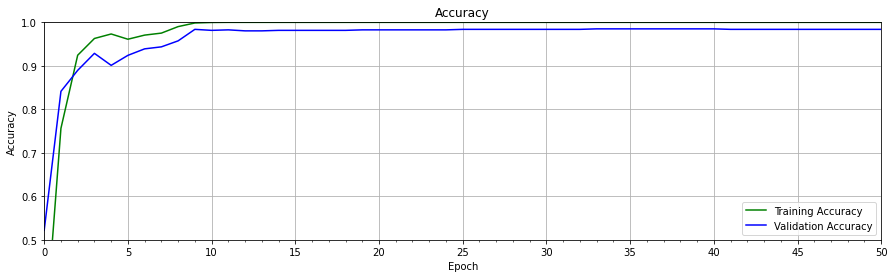

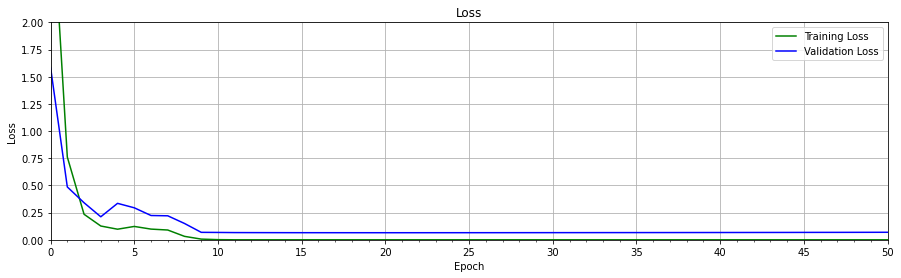

In [20]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])
 
max_loss = 2.0

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## 5 Model Evaluation

In [21]:
# Load saved model.
# Final evaluation accuracy on the validation set.
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

28/28 [==============================] - 49s 2s/step - loss: 0.0662 - accuracy: 0.9851
Model evaluation accuracy: 98.506


In [22]:
def display_wrong_predictions(dataset, checkpoint_dir=None, checkpoint_version=0):
    
    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(), TrainingConfig.checkpoint_dir, f"version_{checkpoint_version}")
        
    # Load saved model.
    model = tf.keras.models.load_model(checkpoint_dir)
    
    plt.figure(figsize=(20, 15))
    num_rows = 4
    num_cols = 5
    class_names = dataset.class_names
    jdx = 0
    
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset:
        
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
        
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            # Plot the images with incorrect predictions
            if pred_idx != truth_idx:
                
                jdx += 1
                
                if jdx > num_rows*num_cols:
                    # Break from the loops if the maximum number of images have been plotted
                    break
                
                ax = plt.subplot(num_rows, num_cols, jdx)
                title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
                title_obj = plt.title(title)
                plt.setp(title_obj, color='r')
                plt.axis("off")
                plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return  

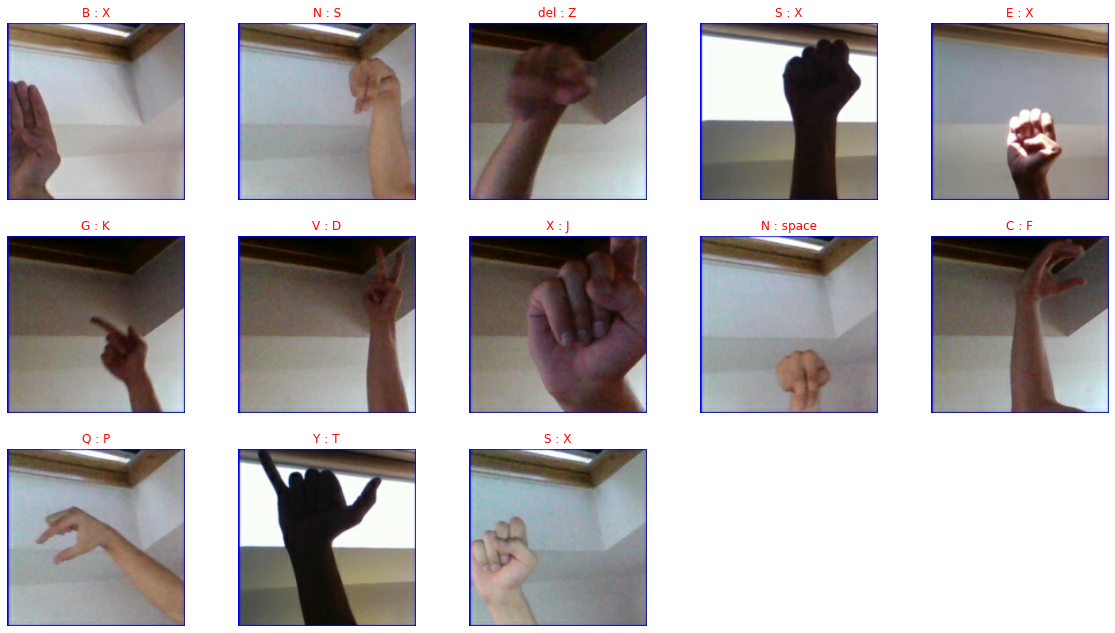

In [23]:
display_wrong_predictions(valid_dataset, TrainingConfig.CHECKPOINT_DIR)

## 6 Conclusion

In this notebook, we showed how you can use **fine-tuning** to make adjustments to the weights in the last few layers of a pre-trained convolutional base to improve the validation accuracy of the model. This is a very common technique that is used to leverage pre-existing models for new datasets. When using this approach, it is recommended that you first train the dense classifier only and then un-freeze the layers in the convolutional base that you wish to fine-tune and the model again (including the dense classifier) at a lower learning rate. 

**Save model**

Once we are happy with the performance of the model, we can save it as a .h5 file, simply using the `save` method.

In [24]:
print(model.summary())
model.save('tf2_asl_classifier.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Load model**

Load model for the rest of the tutorial with the `load_model` method.

In [25]:

model = keras.models.load_model('tf2_asl_classifier.h5')


## 7 Quantization

In order to compile the trained model for deployment on a DPU platform, we must first quantize it. Here we will use the `vitis_quantize` module to convert the floating point model into an INT8 quantized representation. 

In [26]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize

**Quantize model**

By default the `quantize_model` function converts the weights, activations and inputs into 8-bit wide numbers. We can specify different values and configurations using `weight_bit`, `activation_bit` and other parameters. 

In [27]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset=valid_dataset, weight_bit=8, activation_bit=8)

[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 4s 439ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Standalone activation `softmax` layer softmax is not supported.
[VAI INFO] Start Quantize Calibration...
28/28 [==============================] - 177s 6s/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.


**Evaluate quantized model**

In order to evaluate the quantized model, it needs to be re-compiled with the desired loss and evaluation metrics, such as accuracy. Since we are using 8-bit quantization we do not lose much performance, if at all.

In [28]:
quantized_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])
print(f"Model evaluation accuracy: {quantized_model.evaluate(valid_dataset)[1]*100.:.3f}")

28/28 [==============================] - 64s 2s/step - loss: 0.0742 - accuracy: 0.9816
Model evaluation accuracy: 98.161


**Save quantized model**

Once we are happy with the performance of the quantized model, we can save it as a .h5 file, simply using the `save` method.

In [29]:
quantized_model.save('tf2_asl_classifier_quantized.h5')

## 8 Compilation

For this final step we use the Vitis AI compiler `vai_c_tensorflow2` and pass the quantized model as a parameter. 

The target platform (ie. specific DPU architecture) is defined by .arch file.

To support as many platforms as possible, we compile for the following DPU architectures:
- B4096 (ZCU102, ZCU104, UltraZed-EV)
- B3136 (KV260)
- B2304 (Ultra96-V2)
- B1152 (Ultra96-V2+DualCam)
-  B512 (ZUBoard)
-  B128 (ZUBoard+DualCam)

In [30]:
!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier_quantized.h5 \
    --arch ./model/B4096/arch-zcu104.json \
    --output_dir ./model/B4096/ \
    --net_name asl_classifier

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier_quantized.h5 \
    --arch ./model/B3136/arch-kv260.json \
    --output_dir ./model/B3136/ \
    --net_name asl_classifier

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier_quantized.h5 \
    --arch ./model/B2304/arch-b2304-lr.json \
    --output_dir ./model/B2304/ \
    --net_name asl_classifier

!vai_c_tensorflow2 \
    --model ./tf2_dobble_classifier_quantized.h5 \
    --arch ./model/B1152/arch-b1152-hr.json \
    --output_dir ./model/B1152/ \
    --net_name asl_classifier

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier_quantized.h5 \
    --arch ./model/B512/arch-b512-lr.json \
    --output_dir ./model/B512/ \
    --net_name asl_classifier

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier_quantized.h5 \
    --arch ./model/B128/arch-b128-lr.json \
    --output_dir ./model/B128/ \
    --net_name asl_classifier


**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./tf2_asl_classifier_quantized.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/asl_classifier_DPUCZDX8G_ISA1_B4096_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/tf2_asl_classifier_quantized.h5
[INFO] keras version: 2.8.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 57/57 [00:00<00:00, 212.50it/s]             
[INFO] dump xmodel: /tmp/asl_classifier_DPUCZDX8G_ISA1_B4096_org.xmodel
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
[UNILOG][INFO] Graph name: model, with op num: 117
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG]

[UNILOG][INFO] The compiled xmodel's md5sum is 868921c952b392db57807f0749061dc2, and has been saved to "/workspace/./model/B512/md5sum.txt"
**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./tf2_asl_classifier_quantized.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/asl_classifier_0x101000002010208_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/tf2_asl_classifier_quantized.h5
[INFO] keras version: 2.8.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 57/57 [00:00<00:00, 215.67it/s]             
[INFO] dump xmodel: /tmp/asl_classifier_0x101000002010208_org.xmodel
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B128_0101000002010208
[UNILOG][INFO] Graph name: model, with op 